# NYC Facades Condition Alart

workflow:
1. load csv
2. separate 'Safe' and 'Unsafe' building
3. for each group, scrape a photo of the facade according to the building's address
4. split training and testing data
5. build model to predict a if a facade is safe or not

Import libraries

In [30]:
import pandas as pd
import numpy as np

In [31]:
import requests as r

## Extract

In [32]:
url_facade_data = "https://data.cityofnewyork.us/resource/xubg-57si.csv"

In [33]:
facade_con = pd.read_csv(url_facade_data)

## Examin

In [34]:
# lift column disply limit to see more columns
pd.set_option('display.max_columns', None)

In [35]:
#preview data
facade_con.head()

,tr6_no,control_no,filing_type,cycle,bin,house_no,street_name,borough,block,lot,sequence_no,submitted_on,current_status,qewi_name,qewi_bus_name,qewi_bus_street_name,qewi_city,qewi_state,qewi_zip,qewi_nys_lic_no,owner_name,owner_bus_name,owner_bus_street_name,owner_city,owner_zip,owner_state,filing_date,filing_status,prior_cycle_filing_date,prior_status,field_inspection_completed_date,qewi_signed_date,late_filing_amt,failure_to_file_amt,failure_to_collect_amt,comments
0,TR6-716580-7A-N1,716580,Auto-Generated,7,1063335,900,RIVERSIDE DRIVE,MANHATTAN,2136,167,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,55000.0,19000.0,0.0,NaN
1,TR6-716657-7C-N1,716657,Auto-Generated,7,1087050,116,EAST 125 STREET,MANHATTAN,1773,7,NaN,NaN,UNSAFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,18000.0,5000.0,21000.0,Civil Penalty Stopped on: 3/25/2019
2,TR6-815020-8C-N1,815020,Auto-Generated,8,4610766,2,BAY CLUB DRIVE,QUEENS,5893,7501,2.0,NaN,SWARMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,1500.0,0.0,0.0,DUE TO GENERATING ERROR PREMISE RE-ADDED TO FI...
3,TR6-713928-7C-N1,713928,Auto-Generated,7,4610766,2,BAY CLUB DRIVE,QUEENS,5893,7501,2.0,NaN,SWARMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,28000.0,8000.0,0.0,Status changed due to Initial TR6 no: TR6-8139...
4,TR6-812231-8B-N1,812231,Auto-Generated,8,2115272,6305,RIVERDALE AVENUE,BRONX,5958,1,1.0,NaN,SWARMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,5500.0,1000.0,0.0,NaN


In [36]:
# DataFrame data types
facade_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tr6_no                           1000 non-null   object 
 1   control_no                       1000 non-null   int64  
 2   filing_type                      1000 non-null   object 
 3   cycle                            1000 non-null   int64  
 4   bin                              1000 non-null   int64  
 5   house_no                         1000 non-null   object 
 6   street_name                      1000 non-null   object 
 7   borough                          1000 non-null   object 
 8   block                            1000 non-null   int64  
 9   lot                              1000 non-null   int64  
 10  sequence_no                      959 non-null    float64
 11  submitted_on                     958 non-null    object 
 12  current_status       

In [37]:
facade_con.describe(include='all')

,tr6_no,control_no,filing_type,cycle,bin,house_no,street_name,borough,block,lot,sequence_no,submitted_on,current_status,qewi_name,qewi_bus_name,qewi_bus_street_name,qewi_city,qewi_state,qewi_zip,qewi_nys_lic_no,owner_name,owner_bus_name,owner_bus_street_name,owner_city,owner_zip,owner_state,filing_date,filing_status,prior_cycle_filing_date,prior_status,field_inspection_completed_date,qewi_signed_date,late_filing_amt,failure_to_file_amt,failure_to_collect_amt,comments
count,1000,1000.000000,1000,1000.000000,1.000000e+03,1000,1000,1000,1000.000000,1000.000000,959.000000,958,756,958,958,958,958,958,864,864,864,962,962,962,864,864,958,1000,826,825,949,856,994.000000,994.000000,994.000000,181
unique,993,NaN,4,NaN,NaN,611,501,5,NaN,NaN,NaN,277,4,235,248,225,76,4,99,192,555,758,581,78,164,8,273,4,537,3,296,325,NaN,NaN,NaN,153
top,TR6-814993-8A-N1,NaN,Initial,NaN,NaN,2,BROADWAY,MANHATTAN,NaN,NaN,NaN,2020-10-30 00:00:00,UNSAFE,DAVID SALAMON,SALAMON ENGINEERING PLLC,159 WEST 25TH STREET,NEW YORK,NY,10001,PE - 060930,RICHARD MORRISON,PR,24-02 49TH AVENUE,NEW YORK,10016,NY,2020-10-30T00:00:00.000,SWARMP,2013-02-20T00:00:00.000,SAFE,2020-10-28T00:00:00.000,2020-10-27T20:00:00.000,NaN,NaN,NaN,INSPECTION 7/15/15 SUBJECT LETTER SENT 11/3/16
freq,4,NaN,913,NaN,NaN,10,40,637,NaN,NaN,NaN,105,268,33,32,51,490,845,137,32,38,60,25,486,50,839,98,334,22,386,25,22,NaN,NaN,NaN,4
mean,NaN,871523.602000,NaN,8.640000,1.832139e+06,NaN,NaN,NaN,2235.262000,1388.004000,1.229406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12966.901408,4442.655936,2591.549296,NaN
std,NaN,93757.758607,NaN,0.917192,1.191951e+06,NaN,NaN,NaN,2597.075645,2866.986993,1.083917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12121.246777,4071.766987,8846.126081,NaN
min,NaN,600001.000000,NaN,6.000000,1.000005e+06,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,NaN,902009.000000,NaN,9.000000,1.025142e+06,NaN,NaN,NaN,779.500000,16.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250.000000,0.000000,0.000000,NaN
50%,NaN,906297.000000,NaN,9.000000,1.065199e+06,NaN,NaN,NaN,1351.000000,38.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000.000000,5000.000000,0.000000,NaN
75%,NaN,911714.000000,NaN,9.000000,2.116467e+06,NaN,NaN,NaN,2502.750000,100.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17250.000000,6000.000000,0.000000,NaN


How many testers / over how many tests?


In [40]:
facade_con.qewi_name

0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
               ...         
995           EDY B ZINGHER
996           GORDON  SMITH
997           GORDON  SMITH
998    GEORGE D CUTSOGEORGE
999         ROY J SOKOLOSKI
Name: qewi_name, Length: 1000, dtype: object

In [41]:
len(pd.unique(facade_con.qewi_name)) # since 2007 there have been 236 Qualified Exterior Wall Inspector

236

In [44]:
len(pd.unique(facade_con.qewi_bus_name)) # only 13 ispectors are no working privately

249

In [58]:
inspector_inspect_freq = facade_con['qewi_name'].value_counts(sort=True)

In [64]:
inspector_inspect_freq

DAVID  SALAMON          33
JOHN  MONROE            25
RICHARD  KOENIGSBERG    23
BARIS  ACAR             20
RONALD  CAGAN           17
                        ..
BRIAN  O'DONNELL         1
THOMAS  CAPOBIANCO       1
ANTHONY  RENEAUD         1
FRANCESCO  MO            1
ROBERT  LEVINE           1
Name: qewi_name, Length: 235, dtype: int64

In [60]:
# export to csv:
inspector_inspect_freq.to_csv(r'C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\inspector_freq.csv', index = True)

In [74]:
df

,qewi_name
DAVID SALAMON,33
JOHN MONROE,25
RICHARD KOENIGSBERG,23
BARIS ACAR,20
RONALD CAGAN,17
...,...
BRIAN O'DONNELL,1
THOMAS CAPOBIANCO,1
ANTHONY RENEAUD,1
FRANCESCO MO,1


In [96]:
# Import library and dataset
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(inspector_inspect_freq)
 
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

#plt.figure(figsize=(30,4))
# Add a graph in each part

sns.boxplot(df["qewi_name"], ax=ax_box)
sns.distplot(df["qewi_name"], ax=ax_hist)
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

.savefig("output.png")

SyntaxError: invalid syntax (<ipython-input-96-264080cc040f>, line 17)

AttributeError: 'PdfPages' object has no attribute 'figure'

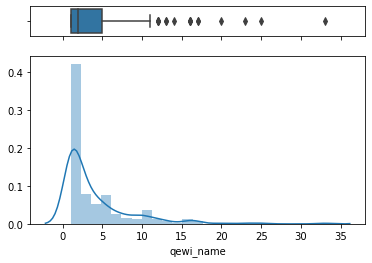

In [91]:
from matplotlib.backends.backend_pdf import PdfPages
#export_pdf.savefig()
with PdfPages(r'C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\names.pdf') as export_pdf:
    df = pd.DataFrame(inspector_inspect_freq)

    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    plt.figure(figsize=(30,4))
    # Add a graph in each part

    sns.boxplot(df["qewi_name"], ax=ax_box)
    sns.distplot(df["qewi_name"], ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    export_pdf.savefig()
    plt.close()

In [46]:
facade_con.shape[0]

1000

In [47]:
len(pd.unique(facade_con.qewi_name)) / facade_con.shape[0]

0.236

Do they tend to be give more "safe" status or "unsafe"?

In [104]:
#inspectors = facade_con.groupby(by='qewi_name')

#print (facade_con.groupby(['qewi_name']).groups)
#.agg('count')
facade_con

,tr6_no,control_no,filing_type,cycle,bin,house_no,street_name,borough,block,lot,sequence_no,submitted_on,current_status,qewi_name,qewi_bus_name,qewi_bus_street_name,qewi_city,qewi_state,qewi_zip,qewi_nys_lic_no,owner_name,owner_bus_name,owner_bus_street_name,owner_city,owner_zip,owner_state,filing_date,filing_status,prior_cycle_filing_date,prior_status,field_inspection_completed_date,qewi_signed_date,late_filing_amt,failure_to_file_amt,failure_to_collect_amt,comments
0,TR6-716580-7A-N1,716580,Auto-Generated,7,1063335,900,RIVERSIDE DRIVE,MANHATTAN,2136,167,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,55000.0,19000.0,0.0,NaN
1,TR6-716657-7C-N1,716657,Auto-Generated,7,1087050,116,EAST 125 STREET,MANHATTAN,1773,7,NaN,NaN,UNSAFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,18000.0,5000.0,21000.0,Civil Penalty Stopped on: 3/25/2019
2,TR6-815020-8C-N1,815020,Auto-Generated,8,4610766,2,BAY CLUB DRIVE,QUEENS,5893,7501,2.0,NaN,SWARMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,1500.0,0.0,0.0,DUE TO GENERATING ERROR PREMISE RE-ADDED TO FI...
3,TR6-713928-7C-N1,713928,Auto-Generated,7,4610766,2,BAY CLUB DRIVE,QUEENS,5893,7501,2.0,NaN,SWARMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,28000.0,8000.0,0.0,Status changed due to Initial TR6 no: TR6-8139...
4,TR6-812231-8B-N1,812231,Auto-Generated,8,2115272,6305,RIVERDALE AVENUE,BRONX,5958,1,1.0,NaN,SWARMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Report Filed,NaN,NaN,NaN,NaN,5500.0,1000.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TR6-600085-NA-I1,600085,Initial,6,1078988,15,BROAD STREET,MANHATTAN,26,7501,1.0,2006-12-04 00:00:00,SAFE,EDY B ZINGHER,ETNA CONSULTING,450 7TH AVENUE,NY,NY,NaN,NaN,NaN,15 BROAD STREET LLC,700 PACIFIC STREET,BKLYN,NaN,NaN,2006-12-04T00:00:00.000,SAFE,2004-04-01T01:00:00.000,SAFE,2005-02-21T00:00:00.000,2006-11-21T00:00:00.000,2750.0,0.0,0.0,NaN
996,TR6-600086-NA-I1,600086,Initial,6,1078991,43,EXCHANGE PLACE,MANHATTAN,26,14,1.0,2005-10-28 00:00:00,SWARMP,GORDON SMITH,GORDON H. SMITH CORPORATION,200 MADISON AVENUE,NEW YORK,NY,NaN,NaN,NaN,WHM ASSOCIATES,820 MORRIS TURNIPIKE,"SHORT HILL,",NaN,NaN,2005-10-28T00:00:00.000,UNSAFE,2005-10-28T00:00:00.000,SAFE,2005-07-28T00:00:00.000,2005-10-14T00:00:00.000,0.0,0.0,0.0,NaN
997,TR6-600086-NA-A1,600086,Amended,6,1078991,43,EXCHANGE PLACE,MANHATTAN,26,14,1.0,2008-09-22 00:00:00,SWARMP,GORDON SMITH,GORDON H. SMITH CORPORATION,200 MADISON AVENUE,NEW YORK,NY,NaN,NaN,NaN,WHM ASSOCIATES,820 MORRIS TURNIPIKE,"SHORT HILL,",NaN,NaN,2008-09-22T00:00:00.000,SWARMP,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
998,TR6-600087-NA-I1,600087,Initial,6,1000826,45,WALL STREET,MANHATTAN,26,21,1.0,2006-03-31 01:00:00,SWARMP,GEORGE D CUTSOGEORGE,CUTSOGEORGE TOOMAN & ALLEN,151 WEST 26TH STREET,NEW YORK,NY,NaN,NaN,NaN,45 WALL STREET LLC,309 EAST 45TH STREET,NY,NaN,NaN,2006-03-31T01:00:00.000,SWARMP,2000-02-23T00:00:00.000,SWARMP,2005-10-19T00:00:00.000,2006-03-20T01:00:00.000,0.0,0.0,0.0,NaN


In [116]:
inspector_note =facade_con[['qewi_name', 'current_status']]

In [118]:
inspector_note

,qewi_name,current_status
0,NaN,No Report Filed
1,NaN,UNSAFE
2,NaN,SWARMP
3,NaN,SWARMP
4,NaN,SWARMP
...,...,...
995,EDY B ZINGHER,SAFE
996,GORDON SMITH,SWARMP
997,GORDON SMITH,SWARMP
998,GEORGE D CUTSOGEORGE,SWARMP


In [120]:
inspector_note.sort_values('qewi_name', inplace=False)

,qewi_name,current_status
239,ABBAS SHAH,SWARMP
61,ABDUL MANNAN,UNSAFE
726,ABDUL MANNAN,SAFE
315,ADAM SZENK,UNSAFE
744,ALAN EPSTEIN,UNSAFE
...,...,...
901,NaN,SAFE
912,NaN,No Report Filed
963,NaN,No Report Filed
965,NaN,No Report Filed


In [135]:
inpector_name_lst = list(inspector_note.qewi_name.unique())

In [214]:
inspect_sum= pd.DataFrame(inpector_name_lst)

In [194]:
import statistics 
from statistics import mode 
  
def most_common(List): 
    if list:
        return(mode(List)) 

In [218]:
tmp_lst = []
for name in inpector_name_lst:
    tmp_row = inspector_note.loc[inspector_note['qewi_name'] == name].dropna(axis=0)
    #print(tmp_row)
    if len(tmp_row) > 0:
        tmp_lst.append(tmp_row.current_status)
    #tmp_lst.append(tmp_row.value_counts()[1])
    #print(tmp_row.current_status.values.tolist())

In [219]:
most_frequent_status = []
for i in tmp_lst:
    #print (i)
    most_frequent_status.append(most_common(pd.DataFrame(i).current_status.tolist()))

In [220]:
inspect_sum['most_freq'] = most_frequent_status

ValueError: Length of values (207) does not match length of index (236)

In [224]:
(len(most_frequent_status) * 10 ) / 100

20.7

In [229]:
len(most_frequent_status) /2 

103.5

In [251]:
higher = np.array(most_frequent_status[:102]).tolist()

In [258]:
lower = np.array(most_frequent_status[102:]).tolist()

In [266]:
higher_lst = [higher.count('UNSAFE'), higher.count('SAFE'), higher.count('SWARMP')]
lower_lst = [lower.count('UNSAFE'), lower.count('SAFE'), lower.count('SWARMP')]
inspect_lbls = ['UNSAFE', 'SAFE', 'SWARMP']

In [281]:
higher_lst

[32, 30, 39]

In [267]:
lower_lst

[27, 40, 38]

In [268]:
from matplotlib import rc

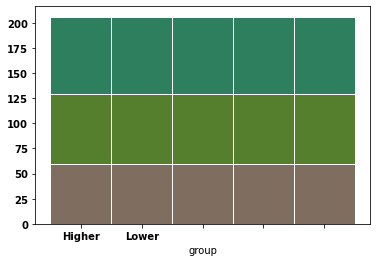

In [278]:
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = [higher_lst[0] + lower_lst[0]]
bars2 = [higher_lst[1] + lower_lst[1]]
bars3 = [higher_lst[2] +lower_lst[2]]
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = ['Higher', 'Lower']
barWidth = 1
 
# Create brown bars
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
 
# Show graphic
plt.show()

In [247]:
mode(np.array(most_frequent_status[102:]).tolist())

'SAFE'

In [130]:
grp = df.groupby('qewi_name')
groups = [grp.get_group(g) for g in grp.groups]
groups[-5:]

[                 qewi_name
 RONALD  CAGAN           17
 WILLIAM  STRUTH         17,
              qewi_name
 BARIS  ACAR         20,
                       qewi_name
 RICHARD  KOENIGSBERG         23,
               qewi_name
 JOHN  MONROE         25,
                 qewi_name
 DAVID  SALAMON         33]

In [117]:
inspector_note.mode

<bound method DataFrame.mode of                 qewi_name   current_status
0                     NaN  No Report Filed
1                     NaN           UNSAFE
2                     NaN           SWARMP
3                     NaN           SWARMP
4                     NaN           SWARMP
..                    ...              ...
995         EDY B ZINGHER             SAFE
996         GORDON  SMITH           SWARMP
997         GORDON  SMITH           SWARMP
998  GEORGE D CUTSOGEORGE           SWARMP
999       ROY J SOKOLOSKI           SWARMP

[1000 rows x 2 columns]>

How many buildings change their status 

How many owners live in the house the own?

In [ ]:
len(pd.unique(facade_con.qewi_name)) # since 2007 there have been 236 Qualified Exterior Wall Inspector working in NYC

Are some testers more likley to be biased? (give more negetive or more positive in avrage?)

Are there houses with no adress? - No.

In [38]:
facade_con['house_no'].isna().sum()

0

The possible values 'status' of a building's address

In [39]:
#set(facade_con['house_no'].values.tolist())

We can see that, while there are no missing values, some buildings location are actually a range ("1-10") - probably meaning they are a long *'block'* building. 
This will require attantion when we will try to retrive images from google

### separte 'Safe' and 'Unsafe' building

In [27]:
safe_df = facade_con.loc[(facade_con['filing_status'] == 'SAFE')]
unsafe_df = facade_con.loc[(facade_con['filing_status'] == 'UNSAFE')]

In [28]:
# add  'SWARMP' buildings Safe with a Repair and Maintenance Program (building code classification; New York, NY)
swarmp_df = facade_con.loc[(facade_con['filing_status'] == 'SWARMP')]

In [29]:
# merge SAFE and SWARMP
frames = [safe_df, swarmp_df]
safe_mrg_df = pd.concat(frames, sort=False)

In [30]:
unsafe_df.shape

(291, 36)

In [31]:
safe_df.shape

(329, 36)

In [32]:
swarmp_df.shape

(336, 36)

In [33]:
safe_mrg_df.shape

(665, 36)

*QEWI* means Qualified Exterior Wall Inspector

In [29]:
safe_mrg_df

NameError: name 'safe_mrg_df' is not defined

## Get the adresses:

For each DF, add an *address* column who's value's a string concatunating the *house_no*, *street_name*, and 'borough' + Ending with "New York, New York"

In [35]:
safe_mrg_df['address'] = safe_mrg_df['house_no'].astype(str) + ' ' + safe_mrg_df['street_name'].astype(str) + ', ' + safe_mrg_df['borough'].astype(str) + ', New York, New York'
unsafe_df['address'] = unsafe_df['house_no'].astype(str) + ' ' + unsafe_df['street_name'].astype(str) + ', ' + unsafe_df['borough'].astype(str) + ', New York, New York'

<ipython-input-35-68e37cf459b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsafe_df['address'] = unsafe_df['house_no'].astype(str) + ' ' + unsafe_df['street_name'].astype(str) + ', ' + unsafe_df['borough'].astype(str) + ', New York, New York'


## Convert physical addresses to Geographic locations → Latitude and Longitude 

Import libraries

In [36]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster

In [37]:
from geopy.extra.rate_limiter import RateLimiter
geocoder = Nominatim(user_agent = 'ironhack') # notice changing the user_agent name in other projects
geocode = RateLimiter(geocoder.geocode, min_delay_seconds=1) # to delay between geocoding calls

In [38]:
# create location column
safe_mrg_df['location'] = safe_mrg_df['address'].apply(geocode)
unsafe_df['location'] = unsafe_df['address'].apply(geocode)
# create longitude,laatitude and altitude from location column (returns tuple)
unsafe_df['point'] = unsafe_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
safe_mrg_df['point'] = safe_mrg_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)

<ipython-input-38-9c0d0a73564f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsafe_df['location'] = unsafe_df['address'].apply(geocode)
<ipython-input-38-9c0d0a73564f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsafe_df['point'] = unsafe_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)


split point column into latitude, longitude and altitude columns

In [39]:
safe_mrg_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(safe_mrg_df['point'].tolist(), index=safe_mrg_df.index)
unsafe_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(unsafe_df['point'].tolist(), index=unsafe_df.index)

C:\Users\meita\anaconda3\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [40]:
unsafe_df

,tr6_no,control_no,filing_type,cycle,bin,house_no,street_name,borough,block,lot,sequence_no,submitted_on,current_status,qewi_name,qewi_bus_name,qewi_bus_street_name,qewi_city,qewi_state,qewi_zip,qewi_nys_lic_no,owner_name,owner_bus_name,owner_bus_street_name,owner_city,owner_zip,owner_state,filing_date,filing_status,prior_cycle_filing_date,prior_status,field_inspection_completed_date,qewi_signed_date,late_filing_amt,failure_to_file_amt,failure_to_collect_amt,comments,address,location,point,latitude,longitude,altitude
5,TR6-900098-9A-I1,900098,Initial,9,1000842,9,SOUTH WILLIAM STREET,MANHATTAN,29,43,1.0,2020-08-04 00:00:00,UNSAFE,KENDRA LOGAN,KELRA CONSULTANTS,1805 SPRIN VALLEY RD,OSSINING,NY,10562,RA - 034706,SUSAN FOGEL,SOUTH WILLIAM STREET ASSOCIATES LLC,9 SOUTH WILLIAM ST.,NEW YORK,10004,NY,2020-08-04T00:00:00.000,UNSAFE,2018-02-09T00:00:00.000,UNSAFE,2020-07-16T00:00:00.000,2020-06-30T20:00:00.000,3000.0,0.0,2000.0,NaN,"9 SOUTH WILLIAM STREET, MANHATTAN, New York, N...","(Wall Street Inn, 9, South William Street, Fin...","(40.7045847, -74.0102722960055, 0.0)",40.704585,-74.010272,0.0
6,TR6-900112-9C-I2,900112,Initial,9,1000865,99,WALL STREET,MANHATTAN,33,7501,1.0,2020-08-06 00:00:00,UNSAFE,EVAN PETKANAS,STONE ENGINEERING & ARCHITECTURE DP,320 EAST 39 STREET,NEW YORK,NY,10016,PE - 081090,MICHAEL WOLFE,101 Wall Condominium,333 7TH AVE.,NEW YORK,10001,NY,2020-08-20T00:00:00.000,UNSAFE,2013-11-14T00:00:00.000,SWARMP,2020-08-06T00:00:00.000,2020-08-19T20:00:00.000,16250.0,5000.0,0.0,NaN,"99 WALL STREET, MANHATTAN, New York, New York","(99 Wall Street, 99, Wall Street, Financial Di...","(40.7047913, -74.00726150649857, 0.0)",40.704791,-74.007262,0.0
9,TR6-913845-9C-I1,913845,Initial,9,2095365,535,EAST 182 STREET,BRONX,3051,1,1.0,2020-05-05 00:00:00,UNSAFE,DAVID SALAMON,SALAMON ENGINEERING PLLC,330 WEST 38 STREET,NEW YORK,NY,10018,PE - 060930,YESSENIA VELEZ,St. Barnabas Housing Development,862 SOUTHERN BLVD,BRONX,10459,NY,2020-05-05T00:00:00.000,UNSAFE,NaN,NaN,2020-04-08T00:00:00.000,2020-05-04T20:00:00.000,30000.0,16000.0,5000.0,NaN,"535 EAST 182 STREET, BRONX, New York, New York",None,None,NaN,NaN,NaN
13,TR6-903792-9C-I1,903792,Initial,9,1031994,158,WEST 81 STREET,MANHATTAN,1211,52,1.0,2020-10-30 00:00:00,UNSAFE,ELISHA GEIGER,"GEIGER ENGINEER, PC",65 BROADWAY,NEW YORK,NY,10006,PE - 061152,JASON ADAMS,GREYSTONE PROPERTIES 81 LLC,30 VESEY ST,NEW YORK,10007,NY,2020-10-30T00:00:00.000,UNSAFE,2012-06-22T00:00:00.000,SWARMP,2020-10-15T00:00:00.000,2020-09-17T20:00:00.000,14400.0,5000.0,0.0,NaN,"158 WEST 81 STREET, MANHATTAN, New York, New York","(New York, 1884, 1st Avenue, Midtown East, Man...","(40.7587979, -73.9623427, 0.0)",40.758798,-73.962343,0.0
15,TR6-903806-9A-I1,903806,Initial,9,1032166,114,WEST 86 STREET,MANHATTAN,1216,39,1.0,2020-08-07 00:00:00,UNSAFE,PATRICK ORRICO,FRANK SETA & ASSOC.,35 W 35TH STREET,NEW YORK,NY,10001,RA - 017698,ROBERT GILARDIAN,"114 West 86th Street Realty, LLC",315 5TH AVENUE,NEW YORK,10016,NY,2020-08-07T00:00:00.000,UNSAFE,2012-02-23T00:00:00.000,UNSAFE,2020-07-21T00:00:00.000,2020-07-31T20:00:00.000,15250.0,7000.0,46000.0,NaN,"114 WEST 86 STREET, MANHATTAN, New York, New York","(86th Street, West 86th Street, Upper West Sid...","(40.7883389, -73.9765049, 0.0)",40.788339,-73.976505,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,TR6-916947-9B-I1,916947,Initial,9,4206536,135-24,HOOVER AVENUE,QUEENS,9667,15,NaN,2020-05-22 00:00:00,UNSAFE,JOHN MONROE,RAND ENGINEERING & ARCHITECTURE DPC,159 WEST 25TH STREET,NEW YORK,NY,10001,RA - 034900,MARK MOSKOWITZ,Canterbury Realty Associates,50 W 17TH ST,NY,10011,NY,2020-05-22T00:00:00.000,UNSAFE,NaN,NaN,2020-05-13T00:00:00.000,2020-05-14T20:00:00.000,10000.0,6000.0,0.0,NaN,"135-24 HOOVER AVENUE, QUEENS, New York, New York","(135-24, Hoover Avenue, Kew Gardens, Queens, Q...","(40.7137375, -73.8215565, 0.0)",40.713738,-73.821556,0.0
946

remove rows that didn't return a location succusfuly

In [41]:
safe_mrg_df_notnull = safe_mrg_df[pd.notnull(safe_mrg_df["latitude"])]
unsafe_df_notnull = unsafe_df[pd.notnull(unsafe_df["latitude"])]

# export data frames

In [42]:
safe_mrg_df_notnull.to_csv(r'C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\str_view\\safe_mrg_df_notnull.csv', index = False)
unsafe_df_notnull.to_csv(r'C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\str_view\\unsafe_df_notnull.csv', index = False)

# C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\str_view\\safe_mrg_df_notnull.csv

## Visualize dots

In [282]:
map_save_unsafe = folium.Map(
    location=[40.730610,-73.935242], # (lan, lat) of NYC
    tiles='Stamen Toner',
    zoom_start=12,
)

NameError: name 'folium' is not defined

In [283]:
safe_mrg_df_notnull.apply(lambda row:folium.Circle(location=[row["latitude"], row["longitude"]], color='#4a7271', radius=1.5, popup = row["address"]).add_to(map_save_unsafe), axis=1)
unsafe_df_notnull.apply(lambda row:folium.Circle(location=[row["latitude"], row["longitude"]], color='#a3474c', radius=1.5, popup = row["address"]).add_to(map_save_unsafe), axis=1)

map_save_unsafe # disply

NameError: name 'safe_mrg_df_notnull' is not defined

In [49]:
map_save_unsafe.save(f'C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\str_view\\map.html') # works as html but not as pdf

In [60]:
map_html_path = 'C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\str_view\\map.html'

Export our map to png

In [73]:
driver = webdriver.Chrome(PATH)
driver.get(map_html_path)
#Give the map tiles some time to load
time.sleep(5)
driver.save_screenshot('C:\\Users\\meita\\Documents\\GitHub\\data-ft-par-labs\\Projects\\final\\str_view\\map.png')
driver.quit()

In [ ]:
unsafe_df

# Scraping google images using Selenium

In [2]:
unsafe_df['location']

NameError: name 'unsafe_df' is not defined

### Import libraries

General

In [3]:
# for printing current time when crashes and waits
import time
import datetime

# for scraping htmls
from bs4 import BeautifulSoup

# to avoid getting blocked
import random

import requests  # for soup

import re # for regex search
import lxml # better then html detection 
import cchardet # to assit in charecter detection

Webdriver specific

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys # for typing
from selenium.webdriver.chrome.options import Options # for loading the page : start only after loading
# for waiting on elemnts to load:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# being able to 'hover' over an elemnt
from selenium.webdriver.common.action_chains import ActionChains

#Chrome.options.add_argument("--headless")

# for opening the web browser
PATH = "C:\\Program Files (x86)\\chromedriver.exe" 

In [5]:
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_experimental_option("detach", True)
#chrome_options.add_argument("--window-size=1024x1024") # makes window sqaure - not needed


## Functions

In [6]:
gmaps_url_base = 'https://www.google.com/maps/place/'

Initialize the webdriver and accept cookies

In [7]:
def open_gmaps(gmaps_url_base):
    driver = webdriver.Chrome(PATH)
    driver.implicitly_wait(10)
    driver.get(gmaps_url_base)

Click on the 'accept cookies' button at start

In [8]:
def accept_cookies():
    # RUN ONLY ONCE
    # allow time for page to load
    #time.sleep(30)
    #WebDriverWait(driver, 60).until(EC.presence_of_element_located((By.XPATH, '//*[@id="searchboxinput"]')))
    # we can't find the elemnt without switching to its frame first:
    driver.switch_to.frame(driver.find_element_by_xpath("//iframe[contains(@src, 'consent.google.com')]")) 
    time.sleep(random.uniform(2, 8)) # look human
    driver.find_element_by_xpath('//*[@id="introAgreeButton"]/span/span').click()
    #driver.switch_to().parentFrame(); # go back to defualt pane
    print("CLICKED: cockies")

Use search bar

In [9]:
def search_location(address):
    time.sleep(random.uniform(2, 5)) # look human"
    driver.implicitly_wait(10)
    search_bar = driver.find_element_by_xpath('//*[@id="searchbox-searchbutton"]')
    search_bar.send_keys(f"{address}",Keys.ENTER) # type the 'address' (function input) and press 'Enter'

Try and move to street view

In [10]:
def clk_str_view():
    time.sleep(random.uniform(2, 5)) # look human
    
    # Is there more than 1 result?
    if len(driver.find_elements_by_css_selector('.section-partial-interpretation-title')) > 0: # if there's multiple options
        print("Multiple results found\n")
        
        element_to_hover_over = driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[2]/div[2]/div[2]/div[2]/div[1]')
        hover_click = ActionChains(driver).move_to_element(element_to_hover_over).send_keys(Keys.ENTER)
        
        #first_res = driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[2]/div[2]/div[2]/div[2]/div[1]')
        #    //*[@id="pane"]/div/div[1]/div/div/div[2]/div[2]/div[2]/div[2]/div[1]/div[1]/div[1]/div[2]/h3/span
        #first_res.click() # click the first one
        #print(driver.find_elements_by_css_selector('.section-result-content'))
        print("Clicking first\n")
    
    # capture change (if made)
    before_str_view_url = str(driver.current_url)

    # Is there streetview available? 
    tmp_elem = driver.find_elements_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[1]/div[1]/button')
    if len(tmp_elem) > 0:
        tmp_elem[0].click() # try to click and see what happens
        
        if len(driver.find_elements_by_css_selector('#titlecard > div.widget-titlecard.widget-titlecard-show-settings-menu')) > 0:
        #str(driver.current_url) == before_str_view_url:
            print('Streetview exists\n')
            return(True)
        else:
            print('No Streetview\n')
            return(False)

Close side pane

In [11]:
def cls_side_pane():
    driver.find_element_by_xpath('//*[@id="pane"]/div/div[3]/button').click()
    time.sleep(random.uniform(1, 5)) # look human

Hide all besides the image background - **NOTICE** the mark stays 

In [12]:
def visib_hide():    
    # the water mark doesn't remove?
    css_elems = ['.widget-image-header-close',
                '.widget-image-header-scrim',
                '.watermark',
                '.app-viewcard-strip',
                '.scene-footer',
                '#pane',
                '#titlecard']
    
    for elem in css_elems:
        driver.execute_script(f"document.querySelector('{elem}').style.display = 'none';")
        
    time.sleep(random.uniform(1, 3)) # look human

In [13]:
def visib_show():    
    # the water mark doesn't remove?
    css_elems = ['.widget-image-header-close',
                '.widget-image-header-scrim',
                '.watermark',
                '.app-viewcard-strip',
                '.scene-footer',
                '#pane',
                '#titlecard']
    
    for elem in css_elems:
        driver.execute_script(f"document.querySelector('{elem}').style.display = 'unset';")
        
    time.sleep(random.uniform(1, 3)) # look human

In [14]:
def reset_for_search():
    visib_show()
    cls_side_pane() # here it actually 'opens' not as the name suggests
    time.sleep(random.uniform(1, 3)) # look human
    driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[1]/button[1]').click() # click to 'return'

Take screenshot

In [15]:
def scrn_shot(img_num, address):
    driver.save_screenshot(f"./final/str_view/{img_num}_{address}.png") # notice saved location

Pack functions into a larger function

In [16]:
def url_to_image(img_num, address):
    if clk_str_view(): # if ther's a streetview option
        print("Moving to Stretview\n")
        cls_side_pane()
        visib_hide()
        scrn_shot(img_num, address)
        reset_for_search() # go back to main search page > ready for the next search
    # either way, delete what you searched for
    search_bar = driver.find_element_by_xpath('//*[@id="searchbox-searchbutton"]') # find search bar
    search_bar.send_keys(Keys.CONTROL + "a", Keys.BACKSPACE) # first select and delete whatever text exists in the search bar 

# WIP

In [17]:
safe_address_lst = safe_mrg_df.address.tolist()
unsafe_address_lst = unsafe_df.address.tolist()

NameError: name 'safe_mrg_df' is not defined

In [69]:
#unsafe_address_lst

In [80]:
unsafe_address_lst = unsafe_address_lst[10:] # just for tests

In [81]:
len(unsafe_address_lst)

278

In [25]:
video_lst = ['1293 YORK AVENUE, MANHATTAN, New York, New York', '215 EAST GUNHILL ROAD, BRONX, New York, New York', '14 WEST 57 STREET, MANHATTAN, New York, New York']

In [26]:
driver = webdriver.Chrome(PATH)
driver.implicitly_wait(10)
driver.get(gmaps_url_base)
time.sleep(10) # just for video
#open_gmaps(gmaps_url_base)
print('opened window')
accept_cookies()
print('accepted cookies')
for img_num, address in enumerate(video_lst): # change according to what your 
    print(f'Scraping: {img_num} out of: {len(video_lst)}. There are {len(video_lst) - img_num} images left.\n')
    print(f'{address}\n')
    time.sleep(random.uniform(1, 5)) # look human
    #tmp_url = gmaps_url_base + address
    search_location(address)
    time.sleep(random.uniform(3, 10)) # look human
    url_to_image(img_num, address) # for ecach address
    time.sleep(random.uniform(3, 10)) # look human

opened window
CLICKED: cockies
accepted cookies
Scraping: 0 out of: 3. There are 3 images left.

1293 YORK AVENUE, MANHATTAN, New York, New York

Streetview exists

Moving to Stretview

Scraping: 1 out of: 3. There are 2 images left.

215 EAST GUNHILL ROAD, BRONX, New York, New York

Streetview exists

Moving to Stretview

Scraping: 2 out of: 3. There are 1 images left.

14 WEST 57 STREET, MANHATTAN, New York, New York

Streetview exists

Moving to Stretview



In [23]:
driver.quit()

In [47]:
print(safe_mrg_df.address.tolist()[3])
geocode(safe_mrg_df.address.tolist()[3])


1293 YORK AVENUE, MANHATTAN, New York, New York


Location(1293, York Avenue, Lenox Hill, Manhattan Community Board 8, Manhattan, New York County, New York, 10021, United States, (40.7651843, -73.9551931, 0.0))

In [307]:
# NOT CURRENTLY WORKING 
try:
    driver = webdriver.Chrome(PATH)
    driver.implicitly_wait(10)
    driver.get(gmaps_url_base)
    #open_gmaps(gmaps_url_base)
    print('opened window')
    accept_cookies()
    print('accepted cookies')
    for img_num, address in enumerate(safe_address_lst):
        print(address, img_num)
        time.sleep(random.uniform(1, 5)) # look human
        #tmp_url = gmaps_url_base + address
        search_location(address)
        time.sleep(random.uniform(3, 10)) # look human
        url_to_image(img_num, address) # for ecach address
except:
    driver.quit()

opened window
CLICKED: cockies
accepted cookies
2937 8 AVENUE, MANHATTAN, New York, New York 0


# Visualizations

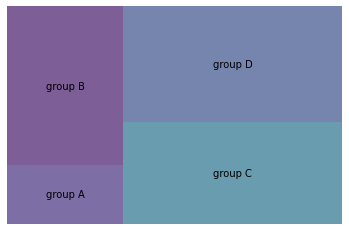

In [28]:
# libraries
import matplotlib.pyplot as plt 
import squarify    # pip install squarify (algorithm for treemap)
 
# If you have 2 lists
squarify.plot(sizes=[7,19,23,26], label=["group A", "group B", "group C", "group D"], alpha=.7 )
plt.axis('off')
plt.show()